In [ ]:
# Spatial neighborhood analysis (SNA, cell type level analysis)

First generate dummy data where two cell types (cell_type_1 and cell_type_2 in "cell_type" cik) are close to each other. Here we assume that cell_type_1 and cell_type_2 are close to each other (concentric cicle) by close_ratio.
Make sure to assume >10 cell types to see the effect of neighborhood enrichment analysis. If this total cell types are less than 10, the analysis may by susceptible to false positive results because cell labels are shuffling in permutation test.


In [6]:
library(spatialCooccur)
library(patchwork)
library(ggplot2)
library(magrittr)
library(dplyr)


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




In [2]:

seed=1234
close_ratio=1  # proportion of cell_type_1 and cell_type_2 that are close to each other
n_types=15  # Number of cell types
max_loc=800 # Maximum x and y coordinates in space
n_cells=500  # Number of total cells
test_type="circle" # "line", "circle", "distribute"
distance_param=20  # distance between cell_type_1 and cell_type_2

df = generate_sim(close_ratio = close_ratio, 
                  n_types = n_types,  
                  max_loc = max_loc,
                  n_cells = n_cells,  
                  test_type = test_type,
                  distance_param = distance_param,  
                  seed=seed)
head(df) 
# x and y: coordinates
# cell_type: cell type

,x,y,cell_type
,<dbl>,<dbl>,<fct>
1,355.4030,392.7360,cell_type_1
2,490.8708,345.9954,cell_type_1
3,451.1619,308.7717,cell_type_1
4,501.4539,430.0083,cell_type_1
5,280.3691,433.8681,cell_type_1
6,389.7839,506.7382,cell_type_1


check the distribution of cell types in the space

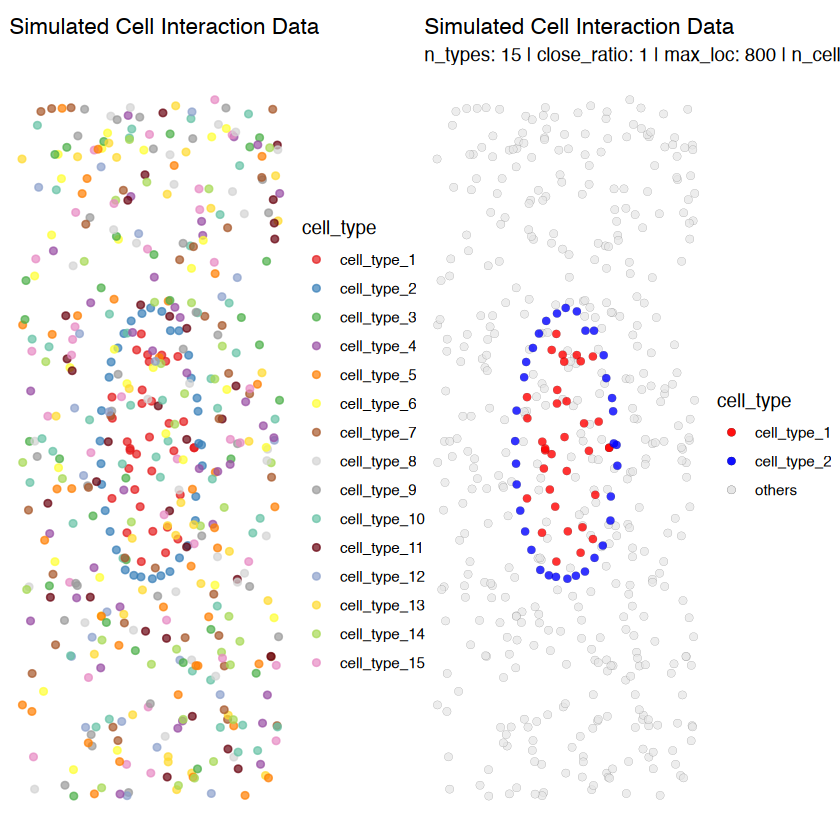

In [ ]:
options
cluster_colors = manual_colors
names(cluster_colors) = paste0("cell_type_",1:n_types)

g1 = ggplot(df, aes(x = x, y = y, color = cell_type)) +
  geom_point(alpha = 0.7) +
  scale_color_manual(values = cluster_colors) +
  theme_void() +
  ggtitle("Simulated Cell Interaction Data")

g2 = ggplot(df %>% dplyr::mutate(cell_type = ifelse(cell_type %in% c("cell_type_1","cell_type_2"),as.character(cell_type),"others")), aes(x = x, y = y, fill = cell_type)) +
  geom_point(data = df %>% dplyr::mutate(cell_type = ifelse(cell_type %in% c("cell_type_1","cell_type_2"),as.character(cell_type),"others")) %>% dplyr::filter(cell_type %in% c("others")),
             alpha = 0.7, size = 2, shape = 21, stroke = 0.05, color = "black") +
  geom_point(data = df %>% dplyr::mutate(cell_type = ifelse(cell_type %in% c("cell_type_1","cell_type_2"),as.character(cell_type),"others")) %>% dplyr::filter(cell_type %in% c("cell_type_1","cell_type_2")),
             alpha = 0.8, size = 2, shape = 21, stroke = 0.05, color = "black") +
  labs(title = "Simulated Cell Interaction Data",
       subtitle = paste("n_types:", n_types, "| close_ratio:", close_ratio, "| max_loc:", max_loc, "| n_cells:", n_cells, "| distance_param:",distance_param)) +
  scale_color_manual(values = c("cell_type_1" = "red", 
                                "cell_type_2" = "blue",
                                "others" = "grey90")) +
  scale_fill_manual(values = c("cell_type_1" = "red", 
                               "cell_type_2" = "blue",
                               "others" = "grey90")) +
  theme_void()
g1|g2